## **Introduction to Artificial Intelligence - Computer Assignment 6 - Reinforcement Learning**

## *Amin Aghakasiri*
## *Student ID : 810101381*

In [3]:
import pygame
import random
import random
import numpy as np
from tkinter import messagebox
import matplotlib.pyplot as plt

### Model 1:

In [1]:
SNAKE_1_Q_TABLE = "model_1_s1.npy"
SNAKE_2_Q_TABLE = "model_1_s2.npy"

WIDTH = 500
HEIGHT = 500

ROWS = 20

class Cube:
    rows = 20
    w = 500

    def __init__(self, start, dirnx=1, dirny=0, color=(255, 0, 0)):
        self.pos = start
        self.dirnx = dirnx
        self.dirny = dirny  # "L", "R", "U", "D"
        self.color = color

    def move(self, dirnx, dirny):
        self.dirnx = dirnx
        self.dirny = dirny
        self.pos = (self.pos[0] + self.dirnx, self.pos[1] + self.dirny)

    def draw(self, surface, eyes=False):
        dis = self.w // self.rows
        i = self.pos[0]
        j = self.pos[1]

        pygame.draw.rect(surface, self.color, (i * dis + 1, j * dis + 1, dis - 2, dis - 2))
        
        if eyes:
            centre = dis // 2
            radius = 3
            circleMiddle = (i * dis + centre - radius, j * dis + 8)
            circleMiddle2 = (i * dis + dis - radius * 2, j * dis + 8)
            pygame.draw.circle(surface, (0, 0, 0), circleMiddle, radius)
            pygame.draw.circle(surface, (0, 0, 0), circleMiddle2, radius)

def redrawWindow(snake_1, snake_2, snack, win):
    win.fill((0, 0, 0))
    drawGrid(WIDTH, ROWS, win)
    snake_1.draw(win)
    snake_2.draw(win)
    snack.draw(win)
    pygame.display.update()
    pass


def drawGrid(w, rows, surface):
    sizeBtwn = w // rows

    x = 0
    y = 0
    for l in range(rows):
        x = x + sizeBtwn
        y = y + sizeBtwn

        pygame.draw.line(surface, (255, 255, 255), (x, 0), (x, w))
        pygame.draw.line(surface, (255, 255, 255), (0, y), (w, y))

    wall_color = (139, 69, 19)  # Brown color
    for i in range(rows):
        pygame.draw.rect(surface, wall_color, (0, i * sizeBtwn, sizeBtwn, sizeBtwn))
        pygame.draw.rect(
            surface,
            wall_color,
            ((rows - 1) * sizeBtwn, i * sizeBtwn, sizeBtwn, sizeBtwn),
        )
        pygame.draw.rect(surface, wall_color, (i * sizeBtwn, 0, sizeBtwn, sizeBtwn))
        pygame.draw.rect(
            surface,
            wall_color,
            (i * sizeBtwn, (rows - 1) * sizeBtwn, sizeBtwn, sizeBtwn),
        )


def randomSnack(rows, item):
    positions = item.body

    while True:
        x = random.randrange(1, rows - 1)
        y = random.randrange(1, rows - 1)
        if len(list(filter(lambda z: z.pos == (x, y), positions))) > 0:
            continue
        else:
            break

    return (x, y)


def save(snake_1, snake_2):
    snake_1.save_q_table(SNAKE_1_Q_TABLE)
    snake_2.save_q_table(SNAKE_2_Q_TABLE)


def reset(snake_1, snake_2):
    snake_1.reset((5, 5))
    snake_2.reset((15, 15))


class Snake_1:
    body = []
    turns = {}

    def __init__(self, color, pos, file_name=None, epsilon_decay=0.998):
        self.color = color
        self.head = Cube(pos, color=color)
        self.body.append(self.head)
        self.dirnx = 0
        self.dirny = 1
        try:
            self.q_table = np.load(file_name)
        except: 
            self.q_table = np.zeros((2,2,2,2,2,2,2,2,2,2,2,2,4))


        self.lr = 0.1
        self.discount_factor = 0.9
        self.epsilon = 0.9
        self.epsilon_decay = epsilon_decay  # Epsilon decay rate
        self.score = 0

    def inc_score(self):
        self.score = self.score + 1
    
    def decay_epsilon(self):
        self.epsilon = max(0.01, self.epsilon * self.epsilon_decay)


    def get_optimal_policy(self, state):
        action = np.argmax(self.q_table[state])
        return action

        
    def make_action(self, state):
        chance = random.random()
        if chance < self.epsilon:
            action = random.randint(0, 3)
        else:
            action = self.get_optimal_policy(state)
        return action

    def update_q_table(self, state, action, next_state, reward):
        self.q_table[state][action] = (1-self.lr) * self.q_table[state][action] \
                                    + (self.lr) * (reward + (self.discount_factor)* np.max(self.q_table[next_state]))

    def get_state(self, snack, other_snake):
        head_x, head_y = self.head.pos
        snack_x, snack_y = snack.pos

        dir_left = int(self.dirnx == -1)
        dir_right = int(self.dirnx == 1)
        dir_up = int(self.dirny == -1)
        dir_down = int(self.dirny == 1)

        snack_up = int(snack_y < head_y)
        snack_down = int(snack_y > head_y)
        snack_right = int(snack_x > head_x)
        snack_left = int(snack_x < head_x)

        wall_up = int((head_y == 1))
        wall_down = int((head_y == ROWS - 2))
        wall_left = int((head_x == 1))
        wall_right = int((head_x == ROWS - 2))

        state = tuple([dir_left, dir_right, dir_up, dir_down, 
                 snack_up, snack_down, snack_right, snack_left, 
                 wall_up, wall_down, wall_left, wall_right])
        
        return state

    def move(self, snack, other_snake):
        state = self.get_state(snack, other_snake)
        action = self.make_action(state)

        if action == 0: # Left
            self.dirnx = -1
            self.dirny = 0
            self.turns[self.head.pos[:]] = [self.dirnx, self.dirny]
        elif action == 1: # Right
            self.dirnx = 1
            self.dirny = 0
            self.turns[self.head.pos[:]] = [self.dirnx, self.dirny]
        elif action == 2: # Up
            self.dirny = -1
            self.dirnx = 0
            self.turns[self.head.pos[:]] = [self.dirnx, self.dirny]
        elif action == 3: # Down
            self.dirny = 1
            self.dirnx = 0
            self.turns[self.head.pos[:]] = [self.dirnx, self.dirny]

        for i, c in enumerate(self.body):
            p = c.pos[:]
            if p in self.turns:
                turn = self.turns[p]
                c.move(turn[0], turn[1])
                if i == len(self.body) - 1:
                    self.turns.pop(p)
            else:
                c.move(c.dirnx, c.dirny)

        next_state = self.get_state(snack, other_snake)
        return state, next_state, action
    
    def check_out_of_board(self):
        headPos = self.head.pos
        if headPos[0] >= ROWS - 1 or headPos[0] < 1 or headPos[1] >= ROWS - 1 or headPos[1] < 1:
            self.reset((random.randint(3, 18), random.randint(3, 18)))
            return True
        return False
    
    def calc_reward(self, snack, other_snake):
        reward = 0
        win_self, win_other = False, False
        head_x, head_y = self.head.pos
        snack_x, snack_y = snack.pos
        wall_up = int(head_y <= 2)
        wall_down = int(head_y >= ROWS - 3)
        wall_left = int(head_x <= 2)
        wall_right = int(head_x >= ROWS - 3)


        # Reward the snake for moving towards the snack
        if ((self.dirny == -1 and snack_y <= head_y) or 
            (self.dirny == 1 and snack_y >= head_y) or 
            (self.dirnx == -1 and snack_x <= head_x) or 
            (self.dirnx == 1 and snack_x >= head_x)):
            reward += 100
        else:
            reward -= 50

        # Punish the snake for moving towards the wall
        if ((self.dirny == -1 and wall_up) or 
            (self.dirny == 1 and wall_down) or 
            (self.dirnx == -1 and wall_left) or 
            (self.dirnx == 1 and wall_right)):
            reward -= 1000

        # Punish the snake for getting out of the board
        if self.check_out_of_board():
            reward -= 5000 
            win_other = True
            other_snake.score += 1
            reset(self, other_snake)
        
        # Reward the snake for eating
        if self.head.pos == snack.pos:
            self.addCube()
            snack = Cube(randomSnack(ROWS, self), color=(0, 255, 0))
            reward += 5000 
            
        # Punish the snake for hitting itself
        if self.head.pos in list(map(lambda z: z.pos, self.body[1:])):
            reward -= 6000 
            win_other = True
            reset(self, other_snake)
            
            
        if self.head.pos in list(map(lambda z: z.pos, other_snake.body)):
            
            # Punish the snake for hitting the other snake
            if self.head.pos != other_snake.head.pos:
                reward -= 6000 
                win_other = True
            else:
                # Reward the snake for hitting the head of the other snake and being longer
                if len(self.body) > len(other_snake.body):
                    reward += 7000 
                    win_self = True
                
                # Pass if draw
                elif len(self.body) == len(other_snake.body):
                    pass

                # Punish the snake for hitting the head of the other snake and being shorter
                else:
                    reward -= 6000 
                    win_other = True
                    
            reset(self, other_snake)

        return snack, reward, win_self, win_other
    
    def reset(self, pos):
        self.head = Cube(pos, color=self.color)
        self.body = []
        self.body.append(self.head)
        self.turns = {}
        self.dirnx = 0
        self.dirny = 1

    def addCube(self):
        tail = self.body[-1]
        dx, dy = tail.dirnx, tail.dirny

        if dx == 1 and dy == 0:
            self.body.append(Cube((tail.pos[0] - 1, tail.pos[1]), color=self.color))
        elif dx == -1 and dy == 0:
            self.body.append(Cube((tail.pos[0] + 1, tail.pos[1]), color=self.color))
        elif dx == 0 and dy == 1:
            self.body.append(Cube((tail.pos[0], tail.pos[1] - 1), color=self.color))
        elif dx == 0 and dy == -1:
            self.body.append(Cube((tail.pos[0], tail.pos[1] + 1), color=self.color))

        self.body[-1].dirnx = dx
        self.body[-1].dirny = dy

    def draw(self, surface):
        for i, c in enumerate(self.body):
            if i == 0:
                c.draw(surface, True)
            else:
                c.draw(surface)

    def save_q_table(self, file_name):
        np.save(file_name, self.q_table)

In [6]:
def main():
    pygame.init()
    win = pygame.display.set_mode((WIDTH, HEIGHT))

    snake_1 = Snake_1((255, 0, 0), (15, 15), SNAKE_1_Q_TABLE,0)
    snake_2 = Snake_1((255, 255, 0), (5, 5), SNAKE_2_Q_TABLE,0)
    snake_1.addCube()
    snake_2.addCube()

    snack = Cube(randomSnack(ROWS, snake_1), color=(0, 255, 0))

    clock = pygame.time.Clock()
    episode_rewards_1 = []
    episode_rewards_2 = []

    running = True
    while running:
        reward_1 = 0
        reward_2 = 0
        pygame.time.delay(25)
        clock.tick(10) 
        
        for event in pygame.event.get():
    
            if event.type == pygame.QUIT:
                if messagebox.askokcancel("Quit", "Do you want to save the Q-tables?"):
                    save(snake_1, snake_2)
                running = False
                break
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_ESCAPE:
                np.save(SNAKE_1_Q_TABLE, snake_1.q_table)
                np.save(SNAKE_2_Q_TABLE, snake_2.q_table)
                pygame.time.delay(1000)
            
        if not running:
            break

        state_1, new_state_1, action_1 = snake_1.move(snack, snake_2)
        state_2, new_state_2, action_2 = snake_2.move(snack, snake_1)

        snack, reward_1, win_1, win_2 = snake_1.calc_reward(snack, snake_2)
        snack, reward_2, _, _ = snake_2.calc_reward(snack, snake_1)

        if win_1:
            snake_1.inc_score()
        elif win_2:
            snake_2.inc_score()

        
        episode_rewards_1.append(reward_1)
        episode_rewards_2.append(reward_2)

        snake_1.update_q_table(state_1, action_1, new_state_1, reward_1)
        snake_2.update_q_table(state_2, action_2, new_state_2, reward_2)

        snake_1.decay_epsilon()
        snake_2.decay_epsilon()
        
        if pygame.display.get_init():
            redrawWindow(snake_1, snake_2, snack, win)
        else:
            break

    pygame.quit()
    exit()

if __name__ == "__main__":
    main()


: 

### Model 2:

In [4]:
SNAKE_1_Q_TABLE = "model_2_s1.npy"
SNAKE_2_Q_TABLE = "model_2_s2.npy"

WIDTH = 500
HEIGHT = 500

ROWS = 20

class Cube:
    rows = 20
    w = 500

    def __init__(self, start, dirnx=1, dirny=0, color=(255, 0, 0)):
        self.pos = start
        self.dirnx = dirnx
        self.dirny = dirny  # "L", "R", "U", "D"
        self.color = color

    def move(self, dirnx, dirny):
        self.dirnx = dirnx
        self.dirny = dirny
        self.pos = (self.pos[0] + self.dirnx, self.pos[1] + self.dirny)

    def draw(self, surface, eyes=False):
        dis = self.w // self.rows
        i = self.pos[0]
        j = self.pos[1]

        pygame.draw.rect(surface, self.color, (i * dis + 1, j * dis + 1, dis - 2, dis - 2))
        
        if eyes:
            centre = dis // 2
            radius = 3
            circleMiddle = (i * dis + centre - radius, j * dis + 8)
            circleMiddle2 = (i * dis + dis - radius * 2, j * dis + 8)
            pygame.draw.circle(surface, (0, 0, 0), circleMiddle, radius)
            pygame.draw.circle(surface, (0, 0, 0), circleMiddle2, radius)


def redrawWindow(snake_1, snake_2, snack, win):
    win.fill((0, 0, 0))
    drawGrid(WIDTH, ROWS, win)
    snake_1.draw(win)
    snake_2.draw(win)
    snack.draw(win)
    pygame.display.update()
    pass


def drawGrid(w, rows, surface):
    sizeBtwn = w // rows

    x = 0
    y = 0
    for l in range(rows):
        x = x + sizeBtwn
        y = y + sizeBtwn

        pygame.draw.line(surface, (255, 255, 255), (x, 0), (x, w))
        pygame.draw.line(surface, (255, 255, 255), (0, y), (w, y))

    wall_color = (139, 69, 19)  # Brown color
    for i in range(rows):
        pygame.draw.rect(surface, wall_color, (0, i * sizeBtwn, sizeBtwn, sizeBtwn))
        pygame.draw.rect(
            surface,
            wall_color,
            ((rows - 1) * sizeBtwn, i * sizeBtwn, sizeBtwn, sizeBtwn),
        )
        pygame.draw.rect(surface, wall_color, (i * sizeBtwn, 0, sizeBtwn, sizeBtwn))
        pygame.draw.rect(
            surface,
            wall_color,
            (i * sizeBtwn, (rows - 1) * sizeBtwn, sizeBtwn, sizeBtwn),
        )


def randomSnack(rows, item):
    positions = item.body

    while True:
        x = random.randrange(1, rows - 1)
        y = random.randrange(1, rows - 1)
        if len(list(filter(lambda z: z.pos == (x, y), positions))) > 0:
            continue
        else:
            break

    return (x, y)


def save(snake_1, snake_2):
    snake_1.save_q_table(SNAKE_1_Q_TABLE)
    snake_2.save_q_table(SNAKE_2_Q_TABLE)


def reset(snake_1, snake_2):
    snake_1.reset((5, 5))
    snake_2.reset((15, 15))

class Snake_2:
    body = []
    turns = {}

    def __init__(self, color, pos, file_name=None, epsilon_decay=0.998):
        self.color = color
        self.head = Cube(pos, color=color)
        self.body.append(self.head)
        self.dirnx = 0
        self.dirny = 1
        try:
            self.q_table = np.load(file_name)
        except: 
            self.q_table = np.zeros((2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,4))


        self.lr = 0.2 
        self.discount_factor = 0.9 
        self.epsilon = 0.9 
        self.epsilon_decay = epsilon_decay  
        self.score = 0

    def inc_score(self):
        self.score = self.score + 1
    
    def decay_epsilon(self):
        self.epsilon = max(0.01, self.epsilon * self.epsilon_decay)


    def get_optimal_policy(self, state, other_snake):
        head_x, head_y = self.head.pos
        dir_left = int(self.dirnx == -1)
        dir_right = int(self.dirnx == 1)
        dir_up = int(self.dirny == -1)
        dir_down = int(self.dirny == 1)
        action = None

        other_tail_x, other_tail_y = other_snake.body[-1].pos

        tuple_list = [(value, index) for index, value in enumerate(self.q_table[state])]

        sorted_list = sorted(tuple_list, key=lambda x: x[0],reverse=True)

        deleted_action = None
        temp = None
        one_line_left = (head_x - 1 == other_tail_x and head_y == other_tail_y)
        one_line_right = (head_x + 1 == other_tail_x and head_y == other_tail_y)
        one_line_up = (head_y - 1 == other_tail_y and head_x == other_tail_x)
        one_line_down = (head_y + 1 == other_tail_y and head_x == other_tail_x)

        if one_line_left:
            deleted_action = 0
        elif one_line_right:
            deleted_action = 1
        elif one_line_up:
            deleted_action = 2
        elif one_line_down:
            deleted_action = 3

        if deleted_action is not None:
            for i, tup in enumerate(sorted_list):
                if tup[1] == deleted_action:
                    temp = sorted_list.pop(i)

        for i in range(len(sorted_list)):
            action = sorted_list[i][1]
            if action == 0 and head_x != 1 and dir_right == 0: # Left
                break

            elif action == 1 and head_x != ROWS - 2 and dir_left == 0:  # Right
                break

            elif action == 2 and head_y != 1 and dir_down == 0:  # Up
                break

            elif action == 3 and head_y != ROWS - 2 and dir_up == 0:  # Down
                break

            else:
                action = sorted_list[0][1]

        return action
        
    def make_action(self, state, other_snake):
        chance = random.random()
        if chance < self.epsilon:
            action = random.randint(0, 3)
        else:
            action = self.get_optimal_policy(state,other_snake)
        return action

    def update_q_table(self, state, action, next_state, reward):
        self.q_table[state][action] = (1-self.lr) * self.q_table[state][action] \
                                    + (self.lr) * (reward + (self.discount_factor)* np.max(self.q_table[next_state]))

    def get_state(self, snack, other_snake):
        head_x, head_y = self.head.pos
        snack_x, snack_y = snack.pos

        dir_left = int(self.dirnx == -1)
        dir_right = int(self.dirnx == 1)
        dir_up = int(self.dirny == -1)
        dir_down = int(self.dirny == 1)

        snack_up = int(snack_y < head_y)
        snack_down = int(snack_y > head_y)
        snack_right = int(snack_x > head_x)
        snack_left = int(snack_x < head_x)

        wall_up = int((head_y == 1))
        wall_down = int((head_y == ROWS - 2))
        wall_left = int((head_x == 1))
        wall_right = int((head_x == ROWS - 2))

        snake_left = 0
        snake_right = 0
        snake_up = 0
        snake_down = 0
        for c in self.body + other_snake.body:
            if c.pos == (head_x - 1, head_y):
                snake_left = 1

        for c in self.body + other_snake.body:
            if c.pos == (head_x + 1, head_y):
                snake_right = 1

        for c in self.body + other_snake.body:
            if c.pos == (head_x, head_y - 1):
                snake_up = 1
        
        for c in self.body + other_snake.body:
            if c.pos == (head_x, head_y + 1):
                snake_down = 1

        state = tuple([dir_left, dir_right, dir_up, dir_down, 
                 snack_up, snack_down, snack_right, snack_left, 
                 wall_up, wall_down, wall_left, wall_right,
                 snake_left, snake_right, snake_up, snake_down])
        
        return state

    def move(self, snack, other_snake):
        state = self.get_state(snack, other_snake) # TODO: Create state
        action = self.make_action(state,other_snake)

        if action == 0: # Left
            self.dirnx = -1
            self.dirny = 0
            self.turns[self.head.pos[:]] = [self.dirnx, self.dirny]
        elif action == 1: # Right
            self.dirnx = 1
            self.dirny = 0
            self.turns[self.head.pos[:]] = [self.dirnx, self.dirny]
        elif action == 2: # Up
            self.dirny = -1
            self.dirnx = 0
            self.turns[self.head.pos[:]] = [self.dirnx, self.dirny]
        elif action == 3: # Down
            self.dirny = 1
            self.dirnx = 0
            self.turns[self.head.pos[:]] = [self.dirnx, self.dirny]

        for i, c in enumerate(self.body):
            p = c.pos[:]
            if p in self.turns:
                turn = self.turns[p]
                c.move(turn[0], turn[1])
                if i == len(self.body) - 1:
                    self.turns.pop(p)
            else:
                c.move(c.dirnx, c.dirny)

        next_state = self.get_state(snack, other_snake)
        return state, next_state, action
    
    def check_out_of_board(self):
        headPos = self.head.pos
        if headPos[0] >= ROWS - 1 or headPos[0] < 1 or headPos[1] >= ROWS - 1 or headPos[1] < 1:
            self.reset((random.randint(3, 18), random.randint(3, 18)))
            return True
        return False
    
    def calc_reward(self, snack, other_snake):
        reward = 0
        win_self, win_other = False, False
        head_x, head_y = self.head.pos
        snack_x, snack_y = snack.pos
        wall_up = int(head_y <= 2)
        wall_down = int(head_y >= ROWS - 3)
        wall_left = int(head_x <= 2)
        wall_right = int(head_x >= ROWS - 3)

        current_state = self.get_state(snack, other_snake)

        # Reward the snake for moving towards the snack
        if (((self.dirny == -1) and (snack_x == head_x) and ((head_y - snack_y) <= 3)) or
            ((self.dirny == 1) and (snack_x == head_x) and ((snack_y - head_y) <= 3)) or
            ((self.dirnx == -1) and (snack_y == head_y) and ((head_x - snack_x) <= 3)) or
            ((self.dirnx == 1) and (snack_y == head_y) and ((snack_x - head_x) <= 3))):
            reward += 400

        elif ((self.dirny == -1 and snack_y <= head_y) or 
            (self.dirny == 1 and snack_y >= head_y) or 
            (self.dirnx == -1 and snack_x <= head_x) or 
            (self.dirnx == 1 and snack_x >= head_x)):
            reward += 20
        else:
            reward -= 20

        # Punish the snake for moving towards the wall
        if ((self.dirny == -1 and wall_up) or 
            (self.dirny == 1 and wall_down) or 
            (self.dirnx == -1 and wall_left) or 
            (self.dirnx == 1 and wall_right)):
            reward -= 1000

        # Punish the snake for moving towards itself or other snake
        if ((self.dirnx == -1 and current_state[12]) or
            (self.dirnx == 1 and current_state[13]) or
            (self.dirny == -1 and current_state[14]) or
            (self.dirny == 1 and current_state[15])):
            reward -= 500
        else:
            reward += 500
        
        
        # Punish the snake for getting out of the board
        if self.check_out_of_board():
            reward -= 5000
            win_other = True
            other_snake.score += 1
            reset(self, other_snake)
        
        # Reward the snake for eating
        if self.head.pos == snack.pos:
            self.addCube()
            snack = Cube(randomSnack(ROWS, self), color=(0, 255, 0))
            reward += 6000
        
        # Punish the snake for hitting itself
        if self.head.pos in list(map(lambda z: z.pos, self.body[1:])):
            reward -= 6000
            win_other = True
            reset(self, other_snake)
            
            
        if self.head.pos in list(map(lambda z: z.pos, other_snake.body)):
            
            # Punish the snake for hitting the other snake
            if self.head.pos != other_snake.head.pos:
                reward -= 6000
                win_other = True
            else:
                # Reward the snake for hitting the head of the other snake and being longer
                if len(self.body) > len(other_snake.body):
                    reward += 4000 
                    win_self = True

                # Pass if draw
                elif len(self.body) == len(other_snake.body):
                    pass

                # Punish the snake for hitting the head of the other snake and being shorter
                else:
                    reward -= 5000 
                    win_other = True
                    
            reset(self, other_snake)

        return snack, reward, win_self, win_other
    
    def reset(self, pos):
        self.head = Cube(pos, color=self.color)
        self.body = []
        self.body.append(self.head)
        self.turns = {}
        self.dirnx = 0
        self.dirny = 1

    def addCube(self):
        tail = self.body[-1]
        dx, dy = tail.dirnx, tail.dirny

        if dx == 1 and dy == 0:
            self.body.append(Cube((tail.pos[0] - 1, tail.pos[1]), color=self.color))
        elif dx == -1 and dy == 0:
            self.body.append(Cube((tail.pos[0] + 1, tail.pos[1]), color=self.color))
        elif dx == 0 and dy == 1:
            self.body.append(Cube((tail.pos[0], tail.pos[1] - 1), color=self.color))
        elif dx == 0 and dy == -1:
            self.body.append(Cube((tail.pos[0], tail.pos[1] + 1), color=self.color))

        self.body[-1].dirnx = dx
        self.body[-1].dirny = dy

    def draw(self, surface):
        for i, c in enumerate(self.body):
            if i == 0:
                c.draw(surface, True)
            else:
                c.draw(surface)

    def save_q_table(self, file_name):
        np.save(file_name, self.q_table)
        

In [5]:
def main():
    pygame.init()
    win = pygame.display.set_mode((WIDTH, HEIGHT))

    snake_1 = Snake_2((255, 0, 0), (15, 15), SNAKE_1_Q_TABLE,0)
    snake_2 = Snake_2((255, 255, 0), (5, 5), SNAKE_2_Q_TABLE,0)
    snake_1.addCube()
    snake_2.addCube()

    snack = Cube(randomSnack(ROWS, snake_1), color=(0, 255, 0))

    clock = pygame.time.Clock()
    episode_rewards_1 = []
    episode_rewards_2 = []

    running = True
    while running:
        reward_1 = 0
        reward_2 = 0
        pygame.time.delay(25)
        clock.tick(10) 
        
        for event in pygame.event.get():
    
            if event.type == pygame.QUIT:
                if messagebox.askokcancel("Quit", "Do you want to save the Q-tables?"):
                    save(snake_1, snake_2)
                running = False
                break
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_ESCAPE:
                np.save(SNAKE_1_Q_TABLE, snake_1.q_table)
                np.save(SNAKE_2_Q_TABLE, snake_2.q_table)
                pygame.time.delay(1000)
            
        if not running:
            break

        state_1, new_state_1, action_1 = snake_1.move(snack, snake_2)
        state_2, new_state_2, action_2 = snake_2.move(snack, snake_1)

        snack, reward_1, win_1, win_2 = snake_1.calc_reward(snack, snake_2)
        snack, reward_2, _, _ = snake_2.calc_reward(snack, snake_1)

        if win_1:
            snake_1.inc_score()
        elif win_2:
            snake_2.inc_score()

        
        episode_rewards_1.append(reward_1)
        episode_rewards_2.append(reward_2)

        snake_1.update_q_table(state_1, action_1, new_state_1, reward_1)
        snake_2.update_q_table(state_2, action_2, new_state_2, reward_2)

        snake_1.decay_epsilon()
        snake_2.decay_epsilon()
        
        if pygame.display.get_init(): 
            redrawWindow(snake_1, snake_2, snack, win)
        else:
            break

    pygame.quit()
    exit()

if __name__ == "__main__":
    main()


: 

### Model 3:

In [4]:
SNAKE_1_Q_TABLE = "model_3_s1.npy"
SNAKE_2_Q_TABLE = "model_3_s2.npy"

WIDTH = 500
HEIGHT = 500

ROWS = 20

class Cube:
    rows = 20
    w = 500

    def __init__(self, start, dirnx=1, dirny=0, color=(255, 0, 0)):
        self.pos = start
        self.dirnx = dirnx
        self.dirny = dirny  # "L", "R", "U", "D"
        self.color = color

    def move(self, dirnx, dirny):
        self.dirnx = dirnx
        self.dirny = dirny
        self.pos = (self.pos[0] + self.dirnx, self.pos[1] + self.dirny)

    def draw(self, surface, eyes=False):
        dis = self.w // self.rows
        i = self.pos[0]
        j = self.pos[1]

        pygame.draw.rect(surface, self.color, (i * dis + 1, j * dis + 1, dis - 2, dis - 2))
        
        if eyes:
            centre = dis // 2
            radius = 3
            circleMiddle = (i * dis + centre - radius, j * dis + 8)
            circleMiddle2 = (i * dis + dis - radius * 2, j * dis + 8)
            pygame.draw.circle(surface, (0, 0, 0), circleMiddle, radius)
            pygame.draw.circle(surface, (0, 0, 0), circleMiddle2, radius)


def redrawWindow(snake_1, snake_2, snack, win):
    win.fill((0, 0, 0))
    drawGrid(WIDTH, ROWS, win)
    snake_1.draw(win)
    snake_2.draw(win)
    snack.draw(win)
    pygame.display.update()
    pass


def drawGrid(w, rows, surface):
    sizeBtwn = w // rows

    x = 0
    y = 0
    for l in range(rows):
        x = x + sizeBtwn
        y = y + sizeBtwn

        pygame.draw.line(surface, (255, 255, 255), (x, 0), (x, w))
        pygame.draw.line(surface, (255, 255, 255), (0, y), (w, y))

    wall_color = (139, 69, 19)  # Brown color
    for i in range(rows):
        pygame.draw.rect(surface, wall_color, (0, i * sizeBtwn, sizeBtwn, sizeBtwn))
        pygame.draw.rect(
            surface,
            wall_color,
            ((rows - 1) * sizeBtwn, i * sizeBtwn, sizeBtwn, sizeBtwn),
        )
        pygame.draw.rect(surface, wall_color, (i * sizeBtwn, 0, sizeBtwn, sizeBtwn))
        pygame.draw.rect(
            surface,
            wall_color,
            (i * sizeBtwn, (rows - 1) * sizeBtwn, sizeBtwn, sizeBtwn),
        )


def randomSnack(rows, item):
    positions = item.body

    while True:
        x = random.randrange(1, rows - 1)
        y = random.randrange(1, rows - 1)
        if len(list(filter(lambda z: z.pos == (x, y), positions))) > 0:
            continue
        else:
            break

    return (x, y)


def save(snake_1, snake_2):
    snake_1.save_q_table(SNAKE_1_Q_TABLE)
    snake_2.save_q_table(SNAKE_2_Q_TABLE)


def reset(snake_1, snake_2):
    snake_1.reset((5, 5))
    snake_2.reset((15, 15))

class Snake_3:
    body = []
    turns = {}

    def __init__(self, color, pos, file_name=None, epsilon_decay=0.998):
        self.color = color
        self.head = Cube(pos, color=color)
        self.body.append(self.head)
        self.dirnx = 0
        self.dirny = 1
        try:
            self.q_table = np.load(file_name)
        except: 
            self.q_table = np.zeros((2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,4))


        self.lr = 0.1
        self.discount_factor = 0.9 
        self.epsilon = 1
        self.epsilon_decay = epsilon_decay  
        self.score = 0

    def inc_score(self):
        self.score = self.score + 1
    
    def decay_epsilon(self):
        self.epsilon = max(0.01, self.epsilon * self.epsilon_decay)


    def get_optimal_policy(self, state, other_snake):
        head_x, head_y = self.head.pos
        dir_left = int(self.dirnx == -1)
        dir_right = int(self.dirnx == 1)
        dir_up = int(self.dirny == -1)
        dir_down = int(self.dirny == 1)
        action = None

        other_tail_x, other_tail_y = other_snake.body[-1].pos

        tuple_list = [(value, index) for index, value in enumerate(self.q_table[state])]

        sorted_list = sorted(tuple_list, key=lambda x: x[0],reverse=True)

        deleted_action = None
        temp = None
        one_line_left = (head_x - 1 == other_tail_x and head_y == other_tail_y)
        one_line_right = (head_x + 1 == other_tail_x and head_y == other_tail_y)
        one_line_up = (head_y - 1 == other_tail_y and head_x == other_tail_x)
        one_line_down = (head_y + 1 == other_tail_y and head_x == other_tail_x)

        if one_line_left:
            deleted_action = 0
        elif one_line_right:
            deleted_action = 1
        elif one_line_up:
            deleted_action = 2
        elif one_line_down:
            deleted_action = 3

        if deleted_action is not None:
            for i, tup in enumerate(sorted_list):
                if tup[1] == deleted_action:
                    temp = sorted_list.pop(i)

        for i in range(len(sorted_list)):
            action = sorted_list[i][1]
            if action == 0 and head_x != 1 and dir_right == 0: # Left
                break

            elif action == 1 and head_x != ROWS - 2 and dir_left == 0:  # Right
                break

            elif action == 2 and head_y != 1 and dir_down == 0:  # Up
                break

            elif action == 3 and head_y != ROWS - 2 and dir_up == 0:  # Down
                break

            else:
                action = sorted_list[0][1]

        return action
        
    def make_action(self, state, other_snake):
        chance = random.random()
        if chance < self.epsilon:
            action = random.randint(0, 3)
        else:
            action = self.get_optimal_policy(state,other_snake)
        return action

    def update_q_table(self, state, action, next_state, reward):
        self.q_table[state][action] = (1-self.lr) * self.q_table[state][action] \
                                    + (self.lr) * (reward + (self.discount_factor)* np.max(self.q_table[next_state]))

    def get_state(self, snack, other_snake):
        head_x, head_y = self.head.pos
        snack_x, snack_y = snack.pos

        dir_left = int(self.dirnx == -1)
        dir_right = int(self.dirnx == 1)
        dir_up = int(self.dirny == -1)
        dir_down = int(self.dirny == 1)

        snack_up = int(snack_y < head_y)
        snack_down = int(snack_y > head_y)
        snack_right = int(snack_x > head_x)
        snack_left = int(snack_x < head_x)

        wall_up = int((head_y == 1))
        wall_down = int((head_y == ROWS - 2))
        wall_left = int((head_x == 1))
        wall_right = int((head_x == ROWS - 2))

        snake_left = 0
        snake_right = 0
        snake_up = 0
        snake_down = 0
        for c in self.body + other_snake.body:
            if c.pos == (head_x - 1, head_y):
                snake_left = 1

        for c in self.body + other_snake.body:
            if c.pos == (head_x + 1, head_y):
                snake_right = 1

        for c in self.body + other_snake.body:
            if c.pos == (head_x, head_y - 1):
                snake_up = 1
        
        for c in self.body + other_snake.body:
            if c.pos == (head_x, head_y + 1):
                snake_down = 1

        state = tuple([dir_left, dir_right, dir_up, dir_down, 
                 snack_up, snack_down, snack_right, snack_left, 
                 wall_up, wall_down, wall_left, wall_right,
                 snake_left, snake_right, snake_up, snake_down])
        
        return state

    def move(self, snack, other_snake):
        state = self.get_state(snack, other_snake)
        action = self.make_action(state,other_snake)

        if action == 0: # Left
            self.dirnx = -1
            self.dirny = 0
            self.turns[self.head.pos[:]] = [self.dirnx, self.dirny]
        elif action == 1: # Right
            self.dirnx = 1
            self.dirny = 0
            self.turns[self.head.pos[:]] = [self.dirnx, self.dirny]
        elif action == 2: # Up
            self.dirny = -1
            self.dirnx = 0
            self.turns[self.head.pos[:]] = [self.dirnx, self.dirny]
        elif action == 3: # Down
            self.dirny = 1
            self.dirnx = 0
            self.turns[self.head.pos[:]] = [self.dirnx, self.dirny]

        for i, c in enumerate(self.body):
            p = c.pos[:]
            if p in self.turns:
                turn = self.turns[p]
                c.move(turn[0], turn[1])
                if i == len(self.body) - 1:
                    self.turns.pop(p)
            else:
                c.move(c.dirnx, c.dirny)

        next_state = self.get_state(snack, other_snake)
        return state, next_state, action
    
    def check_out_of_board(self):
        headPos = self.head.pos
        if headPos[0] >= ROWS - 1 or headPos[0] < 1 or headPos[1] >= ROWS - 1 or headPos[1] < 1:
            self.reset((random.randint(3, 18), random.randint(3, 18)))
            return True
        return False
    
    def calc_reward(self, snack, other_snake):
        reward = 0
        win_self, win_other = False, False
        head_x, head_y = self.head.pos
        snack_x, snack_y = snack.pos
        wall_up = int(head_y <= 2)
        wall_down = int(head_y >= ROWS - 3)
        wall_left = int(head_x <= 2)
        wall_right = int(head_x >= ROWS - 3)

        current_state = self.get_state(snack, other_snake)

        # Reward the snake for moving towards the snack
        if (((self.dirny == -1) and (snack_x == head_x) and ((head_y - snack_y) <= 3)) or
            ((self.dirny == 1) and (snack_x == head_x) and ((snack_y - head_y) <= 3)) or
            ((self.dirnx == -1) and (snack_y == head_y) and ((head_x - snack_x) <= 3)) or
            ((self.dirnx == 1) and (snack_y == head_y) and ((snack_x - head_x) <= 3))):
            reward += 400

        elif ((self.dirny == -1 and snack_y <= head_y) or 
            (self.dirny == 1 and snack_y >= head_y) or 
            (self.dirnx == -1 and snack_x <= head_x) or 
            (self.dirnx == 1 and snack_x >= head_x)):
            reward += 20
        else:
            reward -= 20

        # Punish the snake for moving towards the wall
        if ((self.dirny == -1 and wall_up) or 
            (self.dirny == 1 and wall_down) or 
            (self.dirnx == -1 and wall_left) or 
            (self.dirnx == 1 and wall_right)):
            reward -= 1000

        # Punish the snake for moving towards itself or other snake
        if ((self.dirnx == -1 and current_state[12]) or
            (self.dirnx == 1 and current_state[13]) or
            (self.dirny == -1 and current_state[14]) or
            (self.dirny == 1 and current_state[15])):
            reward -= 500
        
        
        # Punish the snake for getting out of the board
        if self.check_out_of_board():
            reward -= 5000
            win_other = True
            other_snake.score += 1
            reset(self, other_snake)
        
        # Reward the snake for eating
        if self.head.pos == snack.pos:
            self.addCube()
            snack = Cube(randomSnack(ROWS, self), color=(0, 255, 0))
            reward += 6000
        
        # Punish the snake for hitting itself
        if self.head.pos in list(map(lambda z: z.pos, self.body[1:])):
            reward -= 8000
            win_other = True
            reset(self, other_snake)
            
            
        if self.head.pos in list(map(lambda z: z.pos, other_snake.body)):
            
            # Punish the snake for hitting the other snake
            if self.head.pos != other_snake.head.pos:
                reward -= 8000
                win_other = True
            else:
                # Reward the snake for hitting the head of the other snake and being longer
                if len(self.body) > len(other_snake.body):
                    reward += 5000 
                    win_self = True
                    
                # Pass if draw
                elif len(self.body) == len(other_snake.body):
                    pass

                # Punish the snake for hitting the head of the other snake and being shorter
                else:
                    reward -= 5000 
                    win_other = True
                    
            reset(self, other_snake)

        return snack, reward, win_self, win_other
    
    def reset(self, pos):
        self.head = Cube(pos, color=self.color)
        self.body = []
        self.body.append(self.head)
        self.turns = {}
        self.dirnx = 0
        self.dirny = 1

    def addCube(self):
        tail = self.body[-1]
        dx, dy = tail.dirnx, tail.dirny

        if dx == 1 and dy == 0:
            self.body.append(Cube((tail.pos[0] - 1, tail.pos[1]), color=self.color))
        elif dx == -1 and dy == 0:
            self.body.append(Cube((tail.pos[0] + 1, tail.pos[1]), color=self.color))
        elif dx == 0 and dy == 1:
            self.body.append(Cube((tail.pos[0], tail.pos[1] - 1), color=self.color))
        elif dx == 0 and dy == -1:
            self.body.append(Cube((tail.pos[0], tail.pos[1] + 1), color=self.color))

        self.body[-1].dirnx = dx
        self.body[-1].dirny = dy

    def draw(self, surface):
        for i, c in enumerate(self.body):
            if i == 0:
                c.draw(surface, True)
            else:
                c.draw(surface)

    def save_q_table(self, file_name):
        np.save(file_name, self.q_table)
        

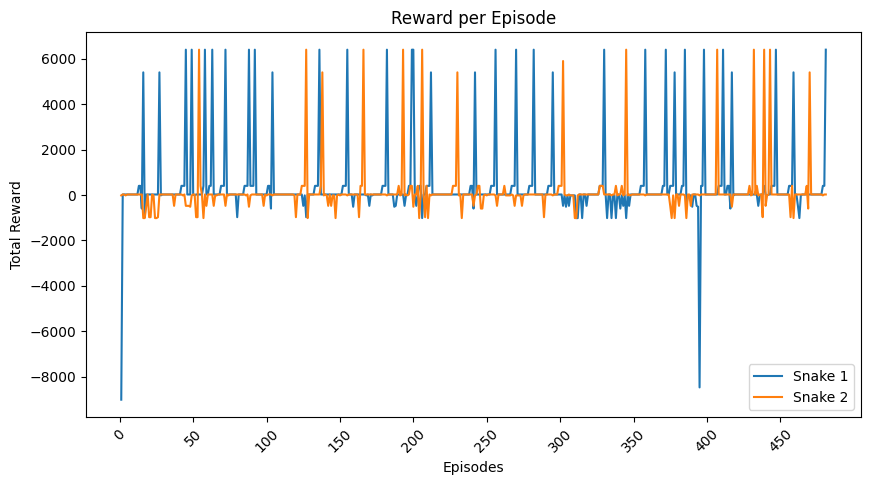

: 

In [5]:
def main():
    pygame.init()
    win = pygame.display.set_mode((WIDTH, HEIGHT))

    snake_1 = Snake_3((255, 0, 0), (15, 15), SNAKE_1_Q_TABLE,0)
    snake_2 = Snake_3((255, 255, 0), (5, 5), SNAKE_2_Q_TABLE,0)
    snake_1.addCube()
    snake_2.addCube()

    snack = Cube(randomSnack(ROWS, snake_1), color=(0, 255, 0))

    clock = pygame.time.Clock()
    episode_rewards_1 = []
    episode_rewards_2 = []

    running = True
    while running:
        reward_1 = 0
        reward_2 = 0
        pygame.time.delay(25)
        clock.tick(10) 
        
        for event in pygame.event.get():
    
            if event.type == pygame.QUIT:
                if messagebox.askokcancel("Quit", "Do you want to save the Q-tables?"):
                    save(snake_1, snake_2)
                running = False
                break
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_ESCAPE:
                np.save(SNAKE_1_Q_TABLE, snake_1.q_table)
                np.save(SNAKE_2_Q_TABLE, snake_2.q_table)
                pygame.time.delay(1000)
            
        if not running:
            break

        state_1, new_state_1, action_1 = snake_1.move(snack, snake_2)
        state_2, new_state_2, action_2 = snake_2.move(snack, snake_1)

        snack, reward_1, win_1, win_2 = snake_1.calc_reward(snack, snake_2)
        snack, reward_2, _, _ = snake_2.calc_reward(snack, snake_1)

        if win_1:
            snake_1.inc_score()
        elif win_2:
            snake_2.inc_score()

        
        episode_rewards_1.append(reward_1)
        episode_rewards_2.append(reward_2)

        snake_1.update_q_table(state_1, action_1, new_state_1, reward_1)
        snake_2.update_q_table(state_2, action_2, new_state_2, reward_2)

        snake_1.decay_epsilon()
        snake_2.decay_epsilon()
        
        if pygame.display.get_init(): 
            redrawWindow(snake_1, snake_2, snack, win)
        else:
            break
    
    pygame.quit()
    episodes = list(range(1, len(episode_rewards_1) + 1))
    plt.figure(figsize=(10, 5))
    plt.plot(episodes, episode_rewards_1, label="Snake 1")
    plt.plot(episodes, episode_rewards_2, label="Snake 2")
    plt.xticks(range(0, len(episodes) + 1, 50), rotation=45)
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('Reward per Episode')
    plt.legend()
    plt.show()
    exit()

if __name__ == "__main__":
    main()


As we can see above, this is the Episode-Reward plot for my third model. Note that this is the plot after the main training phase of hte model (plot for trained and converged game). According to the defenitions of my reward, since the snakes that are in this model belongs to the same class(model) and they had trained together with the same rewards, the plot will be like that (zig-zag shape). Also the ups and downs of the rewards is obvious based on the situation. For example, in the situations that the reward suddenly decreases for a snake, is because of that it loses that game. Also the bigger increases are for eating a snack or winning the game. On the other hand, the small increases and decreases are for living actions like being near itself or other snake or wall (small decrease) or being near a snack or escaping from a near wall (small increase).